<a id = "2"></a><br>
## Load Python Packages and Access Data

In [64]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
import pathlib
import PIL
import cv2
import skimage 
from IPython.display import Image, display
from matplotlib.image import imread
import matplotlib.cm as cm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image

import random
seed = 0
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [65]:
# import dataset
dataset_url = "/kaggle/input/real-life-industrial-dataset-of-casting-product/casting_512x512/casting_512x512/"
data_dir = pathlib.Path(dataset_url)
data_dir

PosixPath('/kaggle/input/real-life-industrial-dataset-of-casting-product/casting_512x512/casting_512x512')

In [66]:
# check the number of rows / number of .jpeg files
image_count = len(list(data_dir.glob('*/*.jpeg')))
print(image_count)

1300


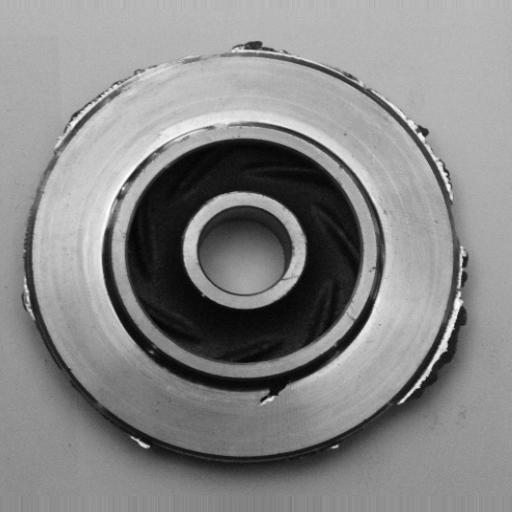

In [67]:
# open the image using the PIL library => for defective_front
def_front = list(data_dir.glob('def_front/*'))
PIL.Image.open(def_front[0])

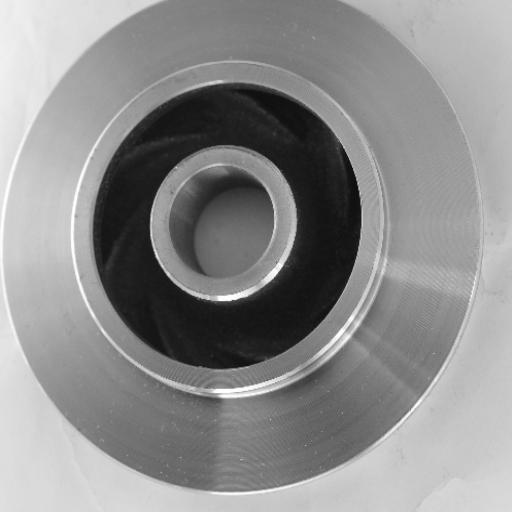

In [68]:
# ok_front list of products
ok_front = list(data_dir.glob('ok_front/*'))
PIL.Image.open(ok_front[0])

In [69]:
sample1= imread(ok_front[0])
sample1.shape

(512, 512, 3)

<a id = "3"></a><br>
## Data Preprocessing (Make It Model-Friendly)

In [70]:
batch_size = 64
epochs = 200
img_height = 299
img_width = 299
img_size = (img_height, img_width)

"image_dataset_from_directory" generates a tf.data.Dataset from image files in a directory. We can prepare our ready to consumption train and validation sets quickly. Let's creat them. I will use 80% for training 20 % for validation

In [71]:
train_set = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    class_names =  ['ok_front', 'def_front'],
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 1300 files belonging to 2 classes.
Using 1040 files for training.


In [72]:
val_set = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    class_names =  ['ok_front', 'def_front'],
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 1300 files belonging to 2 classes.
Using 260 files for validation.


Let's check target variables...

In [73]:
class_names = train_set.class_names
print(class_names)

['ok_front', 'def_front']


We can access samples in the data set via take() method. Let's access some more samples and visualize them. Also we can check their shapes after transformation. This transformation is control by image_size parameter which we define in image_dataset_from_directory.

A quick not about why we set size of images to 299 * 299 is that, I used Xception model to demonstrate transfer learning. This model was originally trained on 299*299 images. Although you can change size parameter (with some limitations), it's always suggested to use original size parameter of pretrained models. 



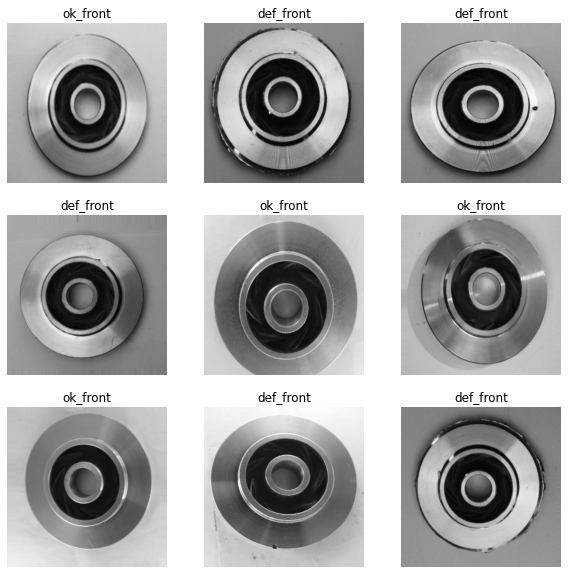

In [74]:
plt.figure(figsize=(10, 10))
for images, labels in train_set.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [75]:
for images, labels in train_set:
  print(images.shape)
  print(labels.shape)
  break

(64, 299, 299, 3)
(64,)


<a id = "4"></a><br>
## Efficient Input Pipelines

I used GPU accelator on this notebook since we have a relatively small data set. However, whether you use GPU or TPU achieving peak performance on training speed requires an efficient input pipeline that delivers data for the next step before the current step has finished. The tf.data API helps to build efficient input pipelines. The following few lines of codes are sufficient for a significant speed increase.

In [76]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_set.cache().shuffle(1300).prefetch(buffer_size=AUTOTUNE)
val_ds = val_set.cache().prefetch(buffer_size=AUTOTUNE)

Quotations from original documentation about what prefetch and cash are actually doing:

* "Prefetching overlaps the preprocessing and model execution of a training step. While the model is executing training step s, the input pipeline is reading the data for step s+1. Doing so reduces the step time to the maximum (as opposed to the sum) of the training and the time it takes to extract the data."

* "The tf.data.Dataset.cache transformation can cache a dataset, either in memory or on local storage. This will save some operations (like file opening and data reading) from being executed during each epoch."


You can find more information on official documantation: Better performance with the tf.data API- https://www.tensorflow.org/guide/data_performance

<a id = "5"></a><br>
## Data Augmentation

Data augmentation is a regularization technique that helps to avoid overfitting. It increases the size and diversity of the training set by adding modified versions of the original data samples. 

Here I will use Keras preprocessing layers to create augmented samples, this way we can get further benefits from GPU. Then we could add augmentation steps inside our model. 

There are many image augmentation techniques that we can use; we could even build custom ones. But from the samples that we observed above, I decided to use the following ones:

* Random flip: Since our parts are symmetrical, we can flip the images both on the horizontal and vertical axis
* Random zoom: Some of the images are zoomed. We can also add zoomed versions of all samples to the training set
* Random contrast: Some images are darker than others. Let's add some random contrast.

In [77]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical",input_shape=(img_height,img_width,3), seed = seed ),
    layers.RandomZoom(0.1, seed = seed ),
    layers.RandomContrast(0.3, seed = seed  )
  ]
)


<a id = "6"></a><br>
## Building a Custom Model

Okay, we take care of everything regarding our data. Now we can start to more fun part. Let's create our model. I will use Keras sequential API. As the name suggests, layers are stacked sequentially, and each layer uses the previous one's output and feeds the later one. 

At the top of the model, we have a rescaling layer to scale pixel values between 0 and 1. This layer will help us for faster convergence. Then augmentation layers cames. Finally we can put our CNN layers and hope they will make the magic. In the end, we have a single neuron Dense layer since this is a binary classification problem.

In [78]:
custom_model = Sequential([
    
  layers.Rescaling(1./255),
  data_augmentation,
  
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),


  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation = 'sigmoid')
])

In [79]:
custom_model.compile(optimizer='adam', 
                     loss='binary_crossentropy', 
                     metrics=['accuracy'])

<a id = "7"></a><br>
## Callbacks

Before training, we can construct some callbacks. Callbacks are useful for the effective training process. I used two callbacks here:

* A custom callback to stop the learning process when a desired accuracy is reached
* A callback to control the learning rate during training.

In [80]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') == 1.0 and logs.get('val_accuracy') == 1.0 :
            print("\nReached 100% accuracy so cancelling training!")
            self.model.stop_training = True

terminate_callback =  myCallback()

This callback will terminate the training process when an accuracy level of 100% is reached. Note that this is a very optimistic callback; we usually can not get 100% accuracy.

In [81]:
# why reduceLROnPlateau() => takes bigger steps 
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, verbose=1,min_delta=0.01,
                              patience=5, min_lr=0.000001)



Learning rate callback will reduce the learning rate during training. ReduceLROnPlateau callback is one of my favorites. It lets the algorithm take bigger steps at the beginning of the learning process. When the improvement on the monitored metric starts to slow down, it will reduce the learning rate for more gentle steps.

If we summarize our callback with words: reduce the learning rate by half when validation loss is not improved by 0.01 in last 5 epochs.

<a id = "8"></a><br>
## Custom Model Performance

Okay let's train our model and get some results...

In [82]:
history1 = custom_model.fit(train_ds, 
                            validation_data=val_ds, 
                            epochs=epochs,
                            callbacks= [reduce_lr, terminate_callback]
)

Epoch 1/200
17/17 [==============================] - 6s 165ms/step - loss: 0.6474 - accuracy: 0.6279 - val_loss: 0.5668 - val_accuracy: 0.6885
Epoch 2/200
17/17 [==============================] - 2s 132ms/step - loss: 0.5933 - accuracy: 0.6875 - val_loss: 0.5353 - val_accuracy: 0.7615
Epoch 3/200
17/17 [==============================] - 2s 131ms/step - loss: 0.5671 - accuracy: 0.7356 - val_loss: 0.5108 - val_accuracy: 0.7615
Epoch 4/200
17/17 [==============================] - 2s 132ms/step - loss: 0.5426 - accuracy: 0.7510 - val_loss: 0.4686 - val_accuracy: 0.8000
Epoch 5/200
17/17 [==============================] - 2s 132ms/step - loss: 0.5430 - accuracy: 0.7308 - val_loss: 0.4757 - val_accuracy: 0.7923
Epoch 6/200
17/17 [==============================] - 2s 131ms/step - loss: 0.5019 - accuracy: 0.7750 - val_loss: 0.4346 - val_accuracy: 0.8038
Epoch 7/200
17/17 [==============================] - 2s 131ms/step - loss: 0.4447 - accuracy: 0.7942 - val_loss: 0.4125 - val_accuracy: 0.8038

In [83]:
custom_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_4 (Rescaling)      (None, 299, 299, 3)       0         
_________________________________________________________________
sequential_4 (Sequential)    (None, 299, 299, 3)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 299, 299, 64)      1792      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 149, 149, 64)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 149, 149, 64)      36928     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 74, 74, 64)       

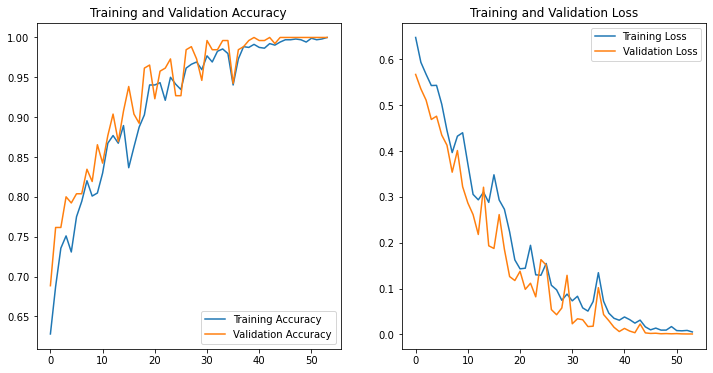

In [84]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

We get a 100% accuracy both on training and validation sets. 

<a id = "9"></a><br>
## Transfer Learning with Xception

When I first heard about transfer learning, it sounded like a crazy thing.

But it works great, and we have a good explanation: Early layers of CNN models behave like feature extractors. Since pre-trained models are trained on large data sets, they already have rich feature representations of different objects. Those features could also help us when we have a small amount of data.

We do that by using a pre-trained model base (i.e., CNN layers) as is and training only the last few layers with our data set. 

Xception is one of that pre-trained models and I will use it here. There are plenty of other pre-trained models on this link you can use another one if you want: https://keras.io/api/applications/

You can check this video for a great explanation about Xception model.

https://www.youtube.com/watch?v=KfV8CJh7hE0

In [85]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(img_height, img_width, 3),
    include_top=False)

Okay, we load the weights of the Xception model from Keras. 

I decided to use the functional API instead of the sequential one here. This choice has no special point; you can also construct the model using sequential API. I just wanted to mention it and show its syntax. 


The functional API is more flexible way than the sequential API. It can handle models with non-linear topology; you can make shared layers, create ensemble models, and manage multiple inputs or output relations. Please check the official documentation for more information https://keras.io/guides/functional_api/



In [86]:
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(img_height, img_width, 3))

x = data_augmentation(inputs)  # Apply random data augmentation

x = keras.layers.Rescaling(scale=1 / 255.0)(x)

x = base_model(x, training=False)

x = keras.layers.Flatten()(x)
x = keras.layers.Dense(128, activation = 'relu')(x)
outputs = keras.layers.Dense(1, activation = 'sigmoid')(x)
pretrained_model = keras.Model(inputs, outputs)

We freezed the base of the pre-trained model, and added some layers at the end. We have rescaling and augmentation layers as usual. Let's trained it on our data set.

In [87]:
pretrained_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [88]:
history2 = pretrained_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks= [reduce_lr, terminate_callback]
)

Epoch 1/200
17/17 [==============================] - 9s 364ms/step - loss: 6.5443 - accuracy: 0.7125 - val_loss: 1.6489 - val_accuracy: 0.7769
Epoch 2/200
17/17 [==============================] - 5s 324ms/step - loss: 0.7937 - accuracy: 0.8740 - val_loss: 0.6319 - val_accuracy: 0.8577
Epoch 3/200
17/17 [==============================] - 5s 325ms/step - loss: 0.2846 - accuracy: 0.9212 - val_loss: 0.0494 - val_accuracy: 0.9808
Epoch 4/200
17/17 [==============================] - 5s 324ms/step - loss: 0.1062 - accuracy: 0.9683 - val_loss: 0.0866 - val_accuracy: 0.9692
Epoch 5/200
17/17 [==============================] - 5s 324ms/step - loss: 0.0556 - accuracy: 0.9808 - val_loss: 0.0141 - val_accuracy: 0.9962
Epoch 6/200
17/17 [==============================] - 5s 324ms/step - loss: 0.0258 - accuracy: 0.9933 - val_loss: 0.0146 - val_accuracy: 0.9962
Epoch 7/200
17/17 [==============================] - 5s 324ms/step - loss: 0.0102 - accuracy: 0.9981 - val_loss: 0.0062 - val_accuracy: 1.0000

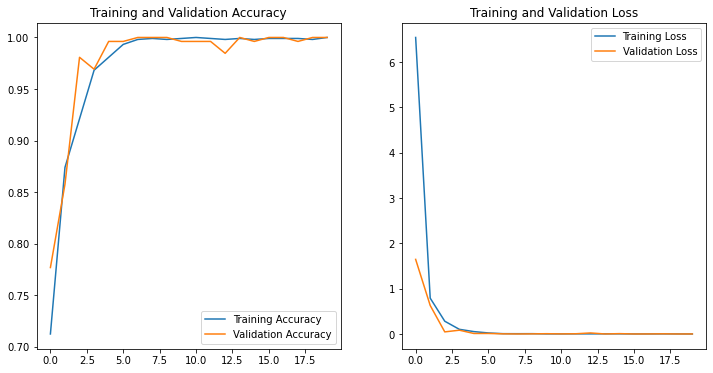

In [89]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [90]:
pretrained_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
sequential_4 (Sequential)    (None, 299, 299, 3)       0         
_________________________________________________________________
rescaling_5 (Rescaling)      (None, 299, 299, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
flatten_5 (Flatten)          (None, 204800)            0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               26214528  
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 129 